In [20]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import nibabel as nib
import tensorflow as tf
import os
import glob
import sys
import time
import ipt_utils
import cnn_utils
import metrics_utils
from math import ceil
import natsort

In [21]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

img_test = glob.glob("C:/users/fungs/BMEN501/data/Test/Image/T*.nii.gz")
mask_test = glob.glob("C:/users/fungs/BMEN501/data/Test/Mask/T*.mask.nii")
img_test = natsort.natsorted(img_test)
mask_test = natsort.natsorted(mask_test)
print(img_test[-1])
print(mask_test[-1])
model_path = "C:/users/fungs/bmen501/network/unet_data_best_10pat_1203.hdf5"
model = cnn_utils.get_unet_mod(nchannels = 1)
model.load_weights(model_path)

dice = np.zeros ((len(img_test),1))

C:/users/fungs/BMEN501/data/Test/Image\TUM45-20191121.nii.gz
C:/users/fungs/BMEN501/data/Test/Mask\TUM45-20191121.nii.gz.mask.nii


(512, 528, 176, 1)


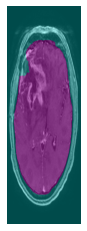

19.27717900276184
(512, 528, 160, 1)


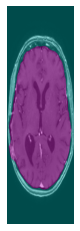

17.812872648239136
(512, 528, 160, 1)


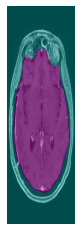

17.732013702392578
(512, 528, 176, 1)


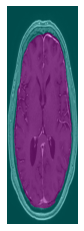

18.817315578460693
(512, 528, 176, 1)


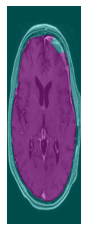

19.053465366363525
(512, 528, 176, 1)


KeyboardInterrupt: 

In [23]:
for ii in range(len(img_test)):
    t = time.time()
    orig_img = nib.load(img_test[ii]).get_fdata()
    orig_img = (orig_img - orig_img.min())/(orig_img.max() - orig_img.min())
    fn = img_test[ii].split("/")[-1]
    if fn.startswith("CC"):
        orig_img = orig_img.transpose(2,0,1)
    else:
        orig_img = orig_img.transpose(1,0,2)
        
    # ensure the image is a multiple of 16 for unet prediction 
    # shape of the original image
    a,b,c = orig_img.shape
    # calculate how many zeros to pad
    bb = 16 - b%16
    cc = 16 - c%16 
    # initialize array with all multiples of 16
    aux_img = np.zeros((a,b+bb,c+cc,1))

    # load image data
    aux_img[:,:b,:c,0] = orig_img

    print(aux_img.shape)
    # model prediction
    predict = model.predict(aux_img, batch_size = 1)
    predict = predict[:,:b,:c,0]
    predict = (predict >0.5).astype(np.uint8)

    # show image
    H,W,Z,_ = aux_img.shape
    plt.figure()
    plt.imshow(aux_img[ceil(H/2),:,:,0], cmap = 'gray')
    plt.imshow(predict[ceil(H/2),:,:], cmap = 'cool',alpha = 0.3)
    plt.axis("off")
    plt.show()

    # compare to manual/ROBEX masks
    mask_manual = nib.load(mask_test[ii]).get_fdata()>0.5
    if fn.startswith("CC"):
        mask_manual = mask_manual.transpose(2,0,1)
    else:
        mask_manual = mask_manual.transpose(1,0,2)
    
    dice[ii,0] = metrics_utils.dice(mask_manual,predict)  
    
    t = time.time() - t
    print(t)

print ("Average dice and standard deviation") 
print (dice.mean(axis = 0)) 
print (dice.std(axis = 0))
 